# PBCO historgram plot of all the modes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
import pandas as pd
import tensorflow as tf
from importlib import reload
import alris_one_third_functions as alris_one_third_functions
reload(alris_one_third_functions)
from alris_one_third_functions import shift_atoms, transform_list_hkl_p63_p65, get_structure_factors , atom_position_list

number_of_modes = 1290

In [2]:
def fun_tf(hkl_list, pars, matrix):
    """
    Fast computation of structure factors with parameter-dependent structure.
    """

    # Get modified structure
    pars_tensor = tf.stack(pars)  # shape (params,)

    #t0 = time()
    atom_shift_list = shift_atoms(matrix , (pars_tensor))
    #print(f"atom_shift_list time: {time() - t0:.4f} seconds")
    atom_shift_list = atom_shift_list[:,0]

    atom_shift_list = tf.unstack(atom_shift_list)
    #convert atom_shift_list to a numpy array
    #t0 = time()
    modified_struct = atom_position_list(*atom_shift_list)
    #print(f"Time taken for atom_positionList: {time() - t0:.4f} seconds")
    
    hkl_list = transform_list_hkl_p63_p65(hkl_list)

    # Get structure factors

    sf_hkl = get_structure_factors(hkl_list, modified_struct)
    intensity = (abs(sf_hkl)) ** 2

    w = tf.constant(0.00032001553565274784, dtype=tf.float32)  # Debye-Waller factor 
    qnorms = tf.norm(tf.cast(hkl_list, tf.float32), axis=1)
    max_intensity = np.max(intensity)
    intensity = np.where(intensity < max_intensity * 0.05, tf.zeros_like(intensity), intensity)  # Ensure no negative intensities
    intensity = intensity * tf.exp(- w* qnorms ** 2)  # Apply Debye-Waller factor
    intensity = intensity / tf.reduce_max(intensity)
    intensity = intensity / tf.reduce_sum(intensity) * 60
    return intensity



In [11]:
def alris_r_factor(data):
    exp_intensity = data['intensity_exp'] / np.max(data['intensity_exp'])
    exp_intensity = exp_intensity / np.sum(exp_intensity) * 60
    simulated_intensity = data['intensity_sim']
    alris_r_factor = np.sum(np.abs(exp_intensity - simulated_intensity)) / np.sum(np.abs(exp_intensity))
    return alris_r_factor

def plot_plane_sim_vs_exp_DIM2(ax, df,r_factor, norm_plane=False):
    #only extract data for h == 0
    exp_data_0 = df.loc[df['k'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1) * 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1) * 500, color='blue', edgecolor="black",
                label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    # #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"h in (h, 0, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"HL plane for K = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()
    # ax.set_xlim(0 , -5.01)
    # ax.set_ylim(-1.01 , 3)


def plot_plane_sim_vs_exp_DIM1(ax, df, r_factor, norm_plane=False):
    
    exp_data_0 = df.loc[df['h'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['k'], exp_data_0['l'], 
               s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
               label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['k'] , exp_data_0['l'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
               label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #grid on
    # ax.grid(True, linestyle='--', alpha=0.7)
    # #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, 15, 0.11))
    ax.set_xlabel(f"k in (0, k, l) [r.l.u.]")
    ax.set_ylabel(f"l in (h, 0, l) [r.l.u.]")
    ax.set_title(f"KL plane for H = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()



def plot_plane_sim_vs_exp_DIM3(ax, df, r_factor, l,norm_plane=False):
    exp_data_0 = df.loc[df['l'] == 0].copy()
    if norm_plane:
        exp_data_0['intensity_exp'] = exp_data_0['intensity_exp'] / np.sum(exp_data_0['intensity_exp']) * 60
    
    ax.scatter(exp_data_0['h'], exp_data_0['k'], 
            s=np.log10(exp_data_0['intensity_sim'] + 1)* 500 , color='red', edgecolor="black",
            label='Sim', marker=MarkerStyle("o"))
    ax.scatter(exp_data_0['h'] , exp_data_0['k'] , s=np.log10(exp_data_0['intensity_exp'] + 1)* 500 , color='blue', edgecolor="black",
            label='Exp', marker=MarkerStyle("o", fillstyle="right"))
    
    #adjust x axis ticks
    # ax.set_xticks(np.arange(0, -5, 0.11))
    # ax.set_yticks(np.arange(0, -5, 0.11))
    ax.set_xlabel(f"h in (h, k, {l}) [r.l.u.]")
    ax.set_ylabel(f"k in (h, k, {l}) [r.l.u.]")
    ax.set_title(f"HK plane for L = 0 (logged) , r-factor: {r_factor:.3f}")
    ax.legend()

In [10]:
def calculate_structure_factor(iteration, histogram_matrix):
    exp_data = pd.read_csv('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/PBCO_1_3/raw_data/1_3_LOGcombined_peaks.csv')
    n_features = exp_data.shape[0]
    n_dim = 3
    hkl_list = exp_data[["h", "k", "l"]].values.tolist()
    hkl_list = tf.convert_to_tensor(hkl_list, dtype=tf.float32)
    features = hkl_list

    labels = exp_data["intensity_exp"].tolist()
    labels = labels / np.max(labels)  # Normalize labels
    labels = labels / np.sum(labels) * 60 # Normalize labels

    # #initialise
    best_model_pars = histogram_matrix[iteration, :]
    best_model_pars = tf.convert_to_tensor(best_model_pars, dtype=tf.float32)   

    matrix = np.loadtxt('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/PBCO_1_3/1_3_matrix.txt', dtype=np.float32)
    #convert matrix to tensor
    matrix = tf.convert_to_tensor(matrix, dtype=tf.float32)
    exp_data['intensity_sim'] = fun_tf(features, best_model_pars , matrix).numpy()
    

    r_factor = alris_r_factor(exp_data)
    print(f"ALRIS R-factor: {r_factor:.3f}")

    return exp_data, r_factor


# 100K data

(156, 2000)
Minimum loss index: 527
Minimum loss value: 0.938
ALRIS R-factor: 0.736
R-factor: 0.736


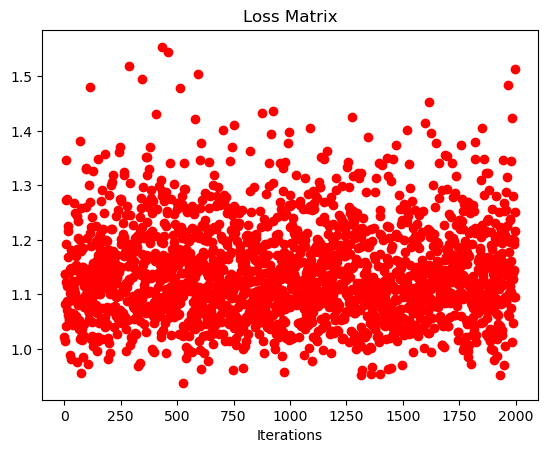

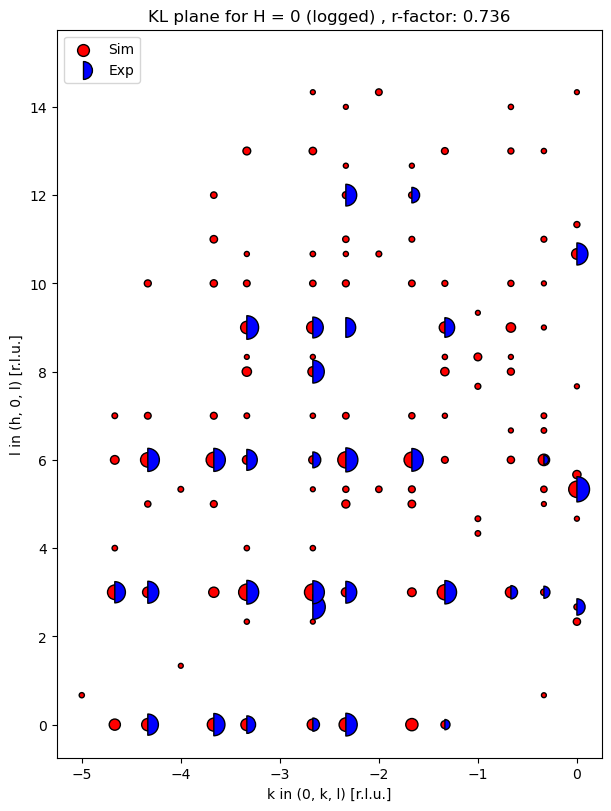

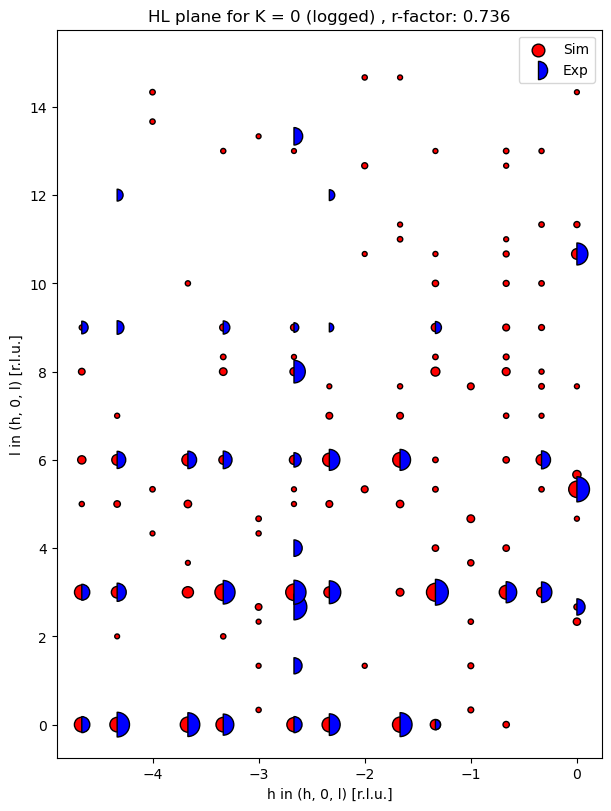

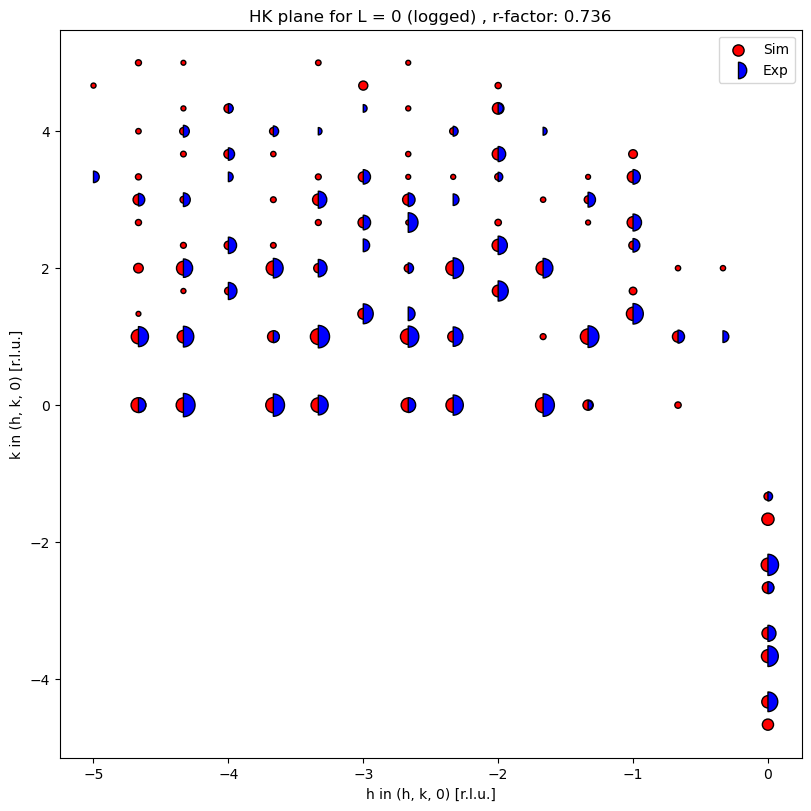

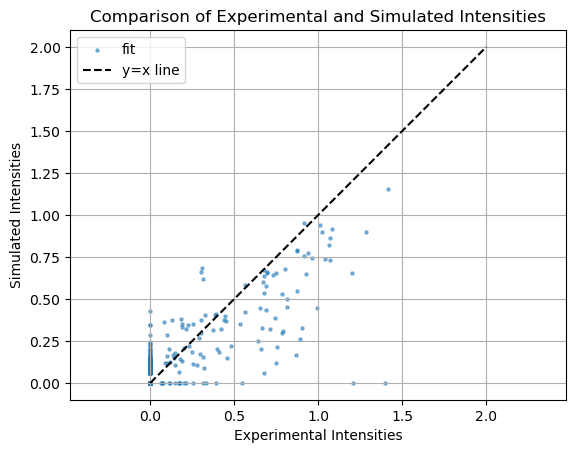

In [12]:
#load file 
number_of_modes = 156
histogram = np.load('C:/Users/User/Desktop/uzh_intern/alrisDistortionFit/PBCO/PBCO_1_3/results/LOG20250831_074654_iters2000_epochs75_lr0.08/all_result_matrix.npz')

#extact histogram matrix
histogram_matrix = histogram['histogram_matrix'] # [modes , iterations]
print(histogram_matrix.shape)

hist_matrix = histogram_matrix.T #[iterations, modes]



loss_matrix = histogram['loss_matrix']
r_factors = histogram['r_factors']
iteration = np.arange(0, len(loss_matrix))


plt.scatter(iteration,loss_matrix, label='Loss over iterations', color='red')
plt.title('Loss Matrix')
plt.xlabel('Iterations')

#extract iterations where the loss matrix is less than a certain threshold
threshold = 0.15
filtered_iterations = iteration[loss_matrix < threshold]

# Plot the filtered loss values
plt.scatter(filtered_iterations, loss_matrix[loss_matrix < threshold], label='Filtered Loss', color='blue')

#find the index where the min loss matrix value is
min_loss_index = np.argmin(loss_matrix)
print(f"Minimum loss index: {min_loss_index}")
print(f"Minimum loss value: {loss_matrix[min_loss_index]:.3f}") 

exp_data , r_factor = calculate_structure_factor(min_loss_index, hist_matrix)
print(f"R-factor: {r_factor:.3f}")

fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM1(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(6,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM2(axs, exp_data, r_factor,norm_plane=True)
plt.show()
fig, axs = plt.subplots(1, 1, figsize=(8,8), constrained_layout=True)
plot_plane_sim_vs_exp_DIM3(axs, exp_data, r_factor, 0,norm_plane=True)
plt.show()

x = np.linspace(0 ,2, 100)
y = x
plt.scatter(exp_data['intensity_exp']/np.sum(exp_data['intensity_exp']) * 60, exp_data['intensity_sim'], s=5, alpha=0.5 , label='fit')
plt.plot(x , y, color='black', linestyle='--', label='y=x line')
plt.legend()
plt.grid(True)
plt.title('Comparison of Experimental and Simulated Intensities')
plt.xlabel('Experimental Intensities')
plt.ylabel('Simulated Intensities')
plt.axis('equal')
plt.show()